In [1]:
import torch
from IPython.display import Image, clear_output  # to display images

clear_output()
print(f"Setup complete. Using torch {torch.__version__} ({torch.cuda.get_device_properties(0).name if torch.cuda.is_available() else 'CPU'})")

Setup complete. Using torch 1.9.1+cpu (CPU)


In [2]:
import os 
import random
import shutil
from sklearn.model_selection import train_test_split
import xml.etree.ElementTree as ET
from xml.dom import minidom
from tqdm import tqdm
from PIL import Image, ImageDraw
import numpy as np
import matplotlib.pyplot as plt

random.seed(108)

In [3]:
ls

 Le volume dans le lecteur C n'a pas de nom.
 Le num‚ro de s‚rie du volume est D0A2-8479

 R‚pertoire de C:\Users\Ben Zahra\Desktop\yolov5

21/10/2021  02:59    <DIR>          .
21/10/2021  02:59    <DIR>          ..
20/10/2021  06:26             3ÿ892 .dockerignore
20/10/2021  06:26                77 .gitattributes
20/10/2021  06:26    <DIR>          .github
20/10/2021  06:26             4ÿ141 .gitignore
21/10/2021  02:27    <DIR>          .ipynb_checkpoints
21/10/2021  01:50    <DIR>          ClothingPascalVOC
20/10/2021  06:26             5ÿ064 CONTRIBUTING.md
20/10/2021  06:26    <DIR>          data
20/10/2021  06:26            15ÿ737 detect.py
20/10/2021  06:26             2ÿ151 Dockerfile
20/10/2021  06:26            16ÿ843 export.py
20/10/2021  06:26             6ÿ380 hubconf.py
20/10/2021  06:26            35ÿ799 LICENSE
21/10/2021  01:12    <DIR>          models
20/10/2021  06:26            15ÿ056 README.md
20/10/2021  06:26               928 requirements.txt
21/10/2021  01:12

In [4]:
cd ClothingPascalVOC

C:\Users\Ben Zahra\Desktop\yolov5\ClothingPascalVOC


In [5]:
ls

 Le volume dans le lecteur C n'a pas de nom.
 Le num‚ro de s‚rie du volume est D0A2-8479

 R‚pertoire de C:\Users\Ben Zahra\Desktop\yolov5\ClothingPascalVOC

21/10/2021  01:50    <DIR>          .
21/10/2021  01:50    <DIR>          ..
21/10/2021  02:58    <DIR>          annotations
21/10/2021  01:49    <DIR>          images
               0 fichier(s)                0 octets
               4 R‚p(s)  121ÿ093ÿ918ÿ720 octets libres


In [6]:
# Function to get the data from XML Annotation
def extract_info_from_xml(xml_file):
    root = ET.parse(xml_file).getroot()
    
    # Initialise the info dict 
    info_dict = {}
    info_dict['bboxes'] = []

    # Parse the XML Tree
    for elem in root:
        # Get the file name 
        if elem.tag == "filename":
            info_dict['filename'] = elem.text
            
        # Get the image size
        elif elem.tag == "size":
            image_size = []
            for subelem in elem:
                image_size.append(int(subelem.text))
            
            info_dict['image_size'] = tuple(image_size)
        
        # Get details of the bounding box 
        elif elem.tag == "object":
            bbox = {}
            for subelem in elem:
                if subelem.tag == "name":
                    bbox["class"] = subelem.text
                    
                elif subelem.tag == "bndbox":
                    for subsubelem in subelem:
                        bbox[subsubelem.tag] = int(subsubelem.text)            
            info_dict['bboxes'].append(bbox)
    
    return info_dict

In [7]:
print(extract_info_from_xml('annotations/Clothing6.xml'))


{'bboxes': [{'class': 'Trousers', 'xmin': 46, 'ymin': 8, 'xmax': 155, 'ymax': 229}], 'filename': 'Clothing6.png', 'image_size': (200, 260, 3)}


In [8]:
# Dictionary that maps class names to IDs
class_name_to_id_mapping = {"Skirts": 0,
                           "Shirts": 1,
                           "Tops": 2,
                           "sunglasses": 3,
                           "Trousers":4,
                           "Jeans":5,
                           "Tshirts":6,
                           "Shoes":7,
                           "Jackets":8}

# Convert the info dict to the required yolo format and write it to disk
def convert_to_yolov5(info_dict):
    print_buffer = []
    
    # For each bounding box
    for b in info_dict["bboxes"]:
        try:
            class_id = class_name_to_id_mapping[b["class"]]
        except KeyError:
            print("Invalid Class. Must be one from ", class_name_to_id_mapping.keys())
        
        # Transform the bbox co-ordinates as per the format required by YOLO v5
        b_center_x = (b["xmin"] + b["xmax"]) / 2 
        b_center_y = (b["ymin"] + b["ymax"]) / 2
        b_width    = (b["xmax"] - b["xmin"])
        b_height   = (b["ymax"] - b["ymin"])
        
        # Normalise the co-ordinates by the dimensions of the image
        image_w, image_h, image_c = info_dict["image_size"]  
        b_center_x /= image_w 
        b_center_y /= image_h 
        b_width    /= image_w 
        b_height   /= image_h 
        
        #Write the bbox details to the file 
        print_buffer.append("{} {:.3f} {:.3f} {:.3f} {:.3f}".format(class_id, b_center_x, b_center_y, b_width, b_height))
        
    # Name of the file which we have to save 
    save_file_name = os.path.join("annotations", info_dict["filename"].replace("png", "txt"))
    
    # Save the annotation to disk
    print("\n".join(print_buffer), file= open(save_file_name, "w"))
  
  

In [9]:
# Get the annotations
annotations = [os.path.join('annotations', x) for x in os.listdir('annotations') if x[-3:] == "xml"]
annotations.sort()

# Convert and save the annotations
for ann in tqdm(annotations):
    info_dict = extract_info_from_xml(ann)
    convert_to_yolov5(info_dict)
annotations = [os.path.join('annotations', x) for x in os.listdir('annotations') if x[-3:] == "txt"]

100%|██████████████████████████████████████████████████████████████████████████████| 504/504 [00:00<00:00, 3635.68it/s]


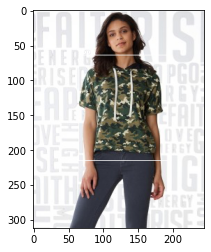

In [10]:
random.seed(0)

class_id_to_name_mapping = dict(zip(class_name_to_id_mapping.values(), class_name_to_id_mapping.keys()))

def plot_bounding_box(image, annotation_list):
    annotations = np.array(annotation_list)
    w, h = image.size
    
    plotted_image = ImageDraw.Draw(image)

    transformed_annotations = np.copy(annotations)
    transformed_annotations[:,[1,3]] = annotations[:,[1,3]] * w
    transformed_annotations[:,[2,4]] = annotations[:,[2,4]] * h 
    
    transformed_annotations[:,1] = transformed_annotations[:,1] - (transformed_annotations[:,3] / 2)
    transformed_annotations[:,2] = transformed_annotations[:,2] - (transformed_annotations[:,4] / 2)
    transformed_annotations[:,3] = transformed_annotations[:,1] + transformed_annotations[:,3]
    transformed_annotations[:,4] = transformed_annotations[:,2] + transformed_annotations[:,4]
    
    for ann in transformed_annotations:
        obj_cls, x0, y0, x1, y1 = ann
        plotted_image.rectangle(((x0,y0), (x1,y1)))
        
        plotted_image.text((x0, y0 - 10), class_id_to_name_mapping[(int(obj_cls))])
    
    plt.imshow(np.array(image))
    plt.show()

# Get any random annotation file 
annotation_file = random.choice(annotations)
with open(annotation_file, "r") as file:
    annotation_list = file.read().split("\n")[:-1]
    annotation_list = [x.split(" ") for x in annotation_list]
    annotation_list = [[float(y) for y in x ] for x in annotation_list]

#Get the corresponding image file
image_file = annotation_file.replace("annotations", "images").replace("txt", "png")
assert os.path.exists(image_file)

#Load the image
image = Image.open(image_file)

#Plot the Bounding Box
plot_bounding_box(image, annotation_list)

In [11]:
# Read images and annotations
images = [os.path.join('images', x) for x in os.listdir('images')]
annotations = [os.path.join('annotations', x) for x in os.listdir('annotations') if x[-3:] == "txt"]

images.sort()
annotations.sort()

# Split the dataset into train-valid-test splits 
train_images, val_images, train_annotations, val_annotations = train_test_split(images, annotations, test_size = 0.2, random_state = 1)
val_images, test_images, val_annotations, test_annotations = train_test_split(val_images, val_annotations, test_size = 0.5, random_state = 1)

In [14]:
!mkdir images\train images\val images\test annotations\train annotations\val annotations\test

In [15]:
#Utility function to move images 
def move_files_to_folder(list_of_files, destination_folder):
    for f in list_of_files:
        try:
            shutil.move(f, destination_folder)
        except:
            print(f)
            assert False

# Move the splits into their folders
move_files_to_folder(train_images, 'images/train')
move_files_to_folder(val_images, 'images/val/')
move_files_to_folder(test_images, 'images/test/')
move_files_to_folder(train_annotations, 'annotations/train/')
move_files_to_folder(val_annotations, 'annotations/val/')
move_files_to_folder(test_annotations, 'annotations/test/')

In [18]:
!mv annotations labels

In [21]:
cd ..

C:\Users\Ben Zahra\Desktop\yolov5


In [23]:
!python train.py --img 640 --cfg yolov5s.yaml --hyp hyp.scratch.yaml --batch 32 --epochs 100 --data clothing_data.yaml --weights yolov5s.pt --workers 24 --name yolo_clothing_det

^C


In [7]:
!python detect.py --source 0 --weights runs/train/yolo_clothing_det/weights/best.pt --conf 0.25 --name yolo_clothing_det

detect: weights=['runs/train/yolo_clothing_det/weights/best.pt'], source=0, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs\detect, name=yolo_clothing_det, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
1/1: 0...  success (inf frames 640x480 at 30.00 FPS)

0: 480x640 Done. (0.266s)
0: 480x640 Done. (0.282s)
0: 480x640 Done. (0.247s)
0: 480x640 Done. (0.274s)
0: 480x640 Done. (0.258s)
0: 480x640 Done. (0.268s)
0: 480x640 Done. (0.262s)
0: 480x640 Done. (0.228s)
0: 480x640 Done. (0.235s)
0: 480x640 Done. (0.237s)
0: 480x640 Done. (0.231s)
0: 480x640 1 Tshirts, Done. (0.238s)
0: 480x640 Done. (0.233s)
0: 480x640 1 Tshirts, Done. (0.236s)
0: 480x640 1 Tshirts, 1 Jackets, Done. (0.245s)
0: 480x640 Done. (0.242s)
0: 480x640 Done. (0.245s)
0: 480x640 Do

YOLOv5  2021-10-21 torch 1.9.1+cpu CPU

Fusing layers... 
Model Summary: 213 layers, 7034398 parameters, 0 gradients, 15.9 GFLOPs



0: 480x640 Done. (0.251s)
0: 480x640 Done. (0.238s)
0: 480x640 Done. (0.239s)
0: 480x640 Done. (0.243s)
0: 480x640 Done. (0.240s)
0: 480x640 Done. (0.235s)
0: 480x640 Done. (0.235s)
0: 480x640 Done. (0.239s)
0: 480x640 Done. (0.232s)
0: 480x640 Done. (0.236s)
0: 480x640 Done. (0.239s)
0: 480x640 Done. (0.230s)
0: 480x640 Done. (0.242s)
0: 480x640 Done. (0.250s)
0: 480x640 Done. (0.242s)
0: 480x640 Done. (0.232s)
0: 480x640 Done. (0.240s)
0: 480x640 Done. (0.234s)
0: 480x640 Done. (0.239s)
0: 480x640 Done. (0.237s)
0: 480x640 Done. (0.232s)
0: 480x640 Done. (0.239s)
0: 480x640 Done. (0.231s)
0: 480x640 Done. (0.235s)
0: 480x640 Done. (0.232s)
0: 480x640 Done. (0.243s)
0: 480x640 Done. (0.235s)
0: 480x640 Done. (0.239s)
0: 480x640 Done. (0.234s)
0: 480x640 Done. (0.224s)
0: 480x640 Done. (0.239s)
0: 480x640 1 Shoes, Done. (0.236s)
0: 480x640 Done. (0.228s)
0: 480x640 Done. (0.242s)
0: 480x640 1 Shoes, Done. (0.242s)
0: 480x640 Done. (0.242s)
0: 480x640 Done. (0.239s)
0: 480x640 1 Jacket

In [6]:
!python detect.py --source ./ClothingPascalVOC/images/test/test2.jpg --weights runs/train/yolo_clothing_det/weights/best.pt --name yolo_clothing_det

detect: weights=['runs/train/yolo_clothing_det/weights/best.pt'], source=./ClothingPascalVOC/images/test/test2.jpg, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs\detect, name=yolo_clothing_det, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
image 1/1 C:\Users\Ben Zahra\Desktop\yolov5\ClothingPascalVOC\images\test\test2.jpg: 640x448 Done. (0.244s)
Speed: 0.0ms pre-process, 244.0ms inference, 0.0ms NMS per image at shape (1, 3, 640, 640)
Results saved to runs\detect\yolo_clothing_det9


YOLOv5  2021-10-21 torch 1.9.1+cpu CPU

Fusing layers... 
Model Summary: 213 layers, 7034398 parameters, 0 gradients, 15.9 GFLOPs


In [1]:
pip install onnx coremltools onnx-simplifier


  Created wheel for coremltools: filename=coremltools-5.0-py3-none-any.whl size=1211830 sha256=c9f7ae84f6da64a12b94dea8d420dd05fdc9c674a78180ec1a4f730bd2d73366
  Stored in directory: c:\users\ben zahra\appdata\local\pip\cache\wheels\1b\7b\0e\35635ebdee828854ff576c0e53c84051bb8a9fb164153ed659
  Created wheel for onnx-simplifier: filename=onnx_simplifier-0.3.6-py3-none-any.whl size=12860 sha256=7264ceb17900e0e8c63023da33e4fe4349d61664f71d200181e8321864c248e0
  Stored in directory: c:\users\ben zahra\appdata\local\pip\cache\wheels\f7\b0\8c\21208ab41ded14656f0165b0837b4689f7082fb2a000d1240d
Successfully built coremltools onnx-simplifier
Note: you may need to restart the kernel to use updated packages.


In [20]:
!python export.py --train --weights runs/train/yolo_clothing_det/weights/best.pt

export: data=data\coco128.yaml, weights=runs/train/yolo_clothing_det/weights/best.pt, imgsz=[640, 640], batch_size=1, device=cpu, half=False, inplace=False, train=True, optimize=False, int8=False, dynamic=False, simplify=False, opset=13, topk_per_class=100, topk_all=100, iou_thres=0.45, conf_thres=0.25, include=['torchscript', 'onnx']

PyTorch: starting from runs\train\yolo_clothing_det\weights\best.pt (14.5 MB)

TorchScript: starting export with torch 1.9.1+cpu...
TorchScript: export success, saved as runs\train\yolo_clothing_det\weights\best.torchscript.pt (28.4 MB)

ONNX: starting export with onnx 1.10.1...
ONNX: export success, saved as runs\train\yolo_clothing_det\weights\best.onnx (28.2 MB)
ONNX: run --dynamic ONNX model inference with: 'python detect.py --weights runs\train\yolo_clothing_det\weights\best.onnx'



YOLOv5  2021-10-21 torch 1.9.1+cpu CPU

Fusing layers... 
Model Summary: 213 layers, 7034398 parameters, 0 gradients, 15.9 GFLOPs


Export complete (4.96s)
Results saved to C:\Users\Ben Zahra\Desktop\yolov5\runs\train\yolo_clothing_det\weights
Visualize with https://netron.app


In [10]:
ls

 Le volume dans le lecteur C n'a pas de nom.
 Le num‚ro de s‚rie du volume est D0A2-8479

 R‚pertoire de C:\Users\Ben Zahra\Desktop\yolov5\runs\train\yolo_clothing_det\weights

22/10/2021  00:55    <DIR>          .
22/10/2021  00:55    <DIR>          ..
22/10/2021  00:55        28ÿ569ÿ647 best.onnx
21/10/2021  07:19        14ÿ498ÿ037 best.pt
22/10/2021  00:55        28ÿ627ÿ340 best.torchscript.pt
21/10/2021  07:19        14ÿ498ÿ037 last.pt
               4 fichier(s)       86ÿ193ÿ061 octets
               2 R‚p(s)  119ÿ751ÿ671ÿ808 octets libres


In [21]:
!python -m onnxsim runs/train/yolo_clothing_det/weights/best.onnx runs/train/yolo_clothing_det/weights/best-sim.onnx

Simplifying...
Checking 0/3...
Checking 1/3...
Checking 2/3...
Ok!


In [19]:
!sudo apt install build-essential libopencv-dev cmake

'sudo' n'est pas reconnu en tant que commande interne
ou externe, un programme ex‚cutable ou un fichier de commandes.
